# Sentinel-2 Data Processing


Welcome! This notebook will guide you through a Python workflow to convert [Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) data from [Standard Archive Format for Europe (SAFE) format](https://sentiwiki.copernicus.eu/web/safe-format) to [Zarr format]().

After completing this notebook, you'll be able to understand the advantages of cloud native data formats like Zarr over SAFE format, download Sentinel-2 imageries and convert them SAFE to Zarr format programmatically. 



The notebook is divided into following sections:

[1. Introduction to cloud-native data formats](#1-introduction-to-cloud-native-data-formats)

[2. Importing necessary libraries](#2-importing-necessary-libraries)

[3. Downloading Sentinel-2 data](#3-downloading-sentinel-2-data)
   
[4. Conversion of data from SAFE to Zarr format](#4-conversion-of-data-from-safe-to-zarr-format)

### 1. Introduction to cloud-native data formats

The SAFE format has been designed to act as a common format for archiving and conveying data within ESA Earth Observation archiving facilities.

Sentinel-2 high resolution multispectral 

https://cpm.pages.eopf.copernicus.eu/eopf-cpm/2.4.0/PSFD/4-storage-formats.html

### 2. Importing necessary libraries

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import geopandas as gpd


import rioxarray
import dask # installed older version due to conflicting issue 
from pathlib import Path
import glob
import xarray as xr
import os

import shutil #extracting files


from credentials import * 

### 3. Downloading Sentinel-2 data

#### 3.1 Defining area of interest

You can provide your study area here in [GeoJSON format](https://geojson.org/) in the same directory as this notebook. If you do not have the GeoJSON file yet, you can create one with tools like [geojson.io](https://geojson.io). We have used an example [study area](AOI.geojson) below. 

<div class="alert alert-block alert-warning" style="width: 50%; margin: auto;">
    <b>Warning:</b> Please remember that the area of interest should be a <em>polygon</em>, it should <em>start and end at the same point</em> and coordinates must be provided in <em>EPSG 4326</em>. 
</div>


The study area is read as [geodataframe](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) using **geopandas** and a new column **geometry_in_WKT** is added to get the [Well-Known Text](https://libgeos.org/specifications/wkt/) format of the geometry for the next steps. 

In [2]:
gdf = gpd.read_file("AOI.geojson")

gdf['geometry_in_WKT'] = gdf["geometry"].apply(lambda geom: geom.wkt)

area_of_interest = gdf.geometry_in_WKT.iloc[0]

area_of_interest

'POLYGON ((23.28414733532665 42.808855658791515, 23.02422284514182 42.68620447104402, 23.221514928053608 42.52177922523441, 23.539896331693313 42.60788768623789, 23.461605822601342 42.754459145844265, 23.28414733532665 42.808855658791515))'

We do some string manipulation below to make `area_of_interest` compatible for API request in the [next section](#321-defining-parameters). 

In [3]:
area_of_interest = area_of_interest + "'" 
area_of_interest

"POLYGON ((23.28414733532665 42.808855658791515, 23.02422284514182 42.68620447104402, 23.221514928053608 42.52177922523441, 23.539896331693313 42.60788768623789, 23.461605822601342 42.754459145844265, 23.28414733532665 42.808855658791515))'"

#### 3.2 Downloading data

There are several ways you can download Sentinel-2 data from Python. One can use [Earth Engine Python API](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api), [sentinelsat](https://sentinelsat.readthedocs.io/en/stable/), [sentinelhub](https://sentinelhub-py.readthedocs.io/en/latest/index.html) and many more.

In this notebook, we will be using [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/) and its available APIs, in particular [OData](https://documentation.dataspace.copernicus.eu/APIs/OData.html), one of the [Catalog APIs](https://dataspace.copernicus.eu/analyse/apis/catalogue-apis). 


##### 3.2.1 Defining parameters

Here, we define the parameters for the mission, start date and end data of the imageries captured. The bounding box of the study area comes from [section 3.1](#321-defining-parameters). 

Please feel free to make changes to **start_date**, **end_date** and **area_of_interest** as per your need.

In [5]:
start_date = "2023-05-01"
end_date = "2023-05-12"
data_collection = "SENTINEL-2"

The URL for the API request is defined below with our parameters. 

We filter the catalogue using **start_date**, **end_date**, **satellite** and **area_of_interest**. But there are more options to filter the catalogue. You can find more about those [here](https://documentation.dataspace.copernicus.eu/APIs/OData.html).


In [6]:
url = (
    f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
    f"$filter=Collection/Name eq '{data_collection}' "
    f"and OData.CSC.Intersects(area=geography'SRID=4326;{area_of_interest}) "
    f"and ContentDate/Start gt {start_date}T00:00:00.000Z "
    f"and ContentDate/Start lt {end_date}T00:00:00.000Z"
)

The first line of code `json = requests.get(url).json()` requests and receives the response from the server, parses the [JSON data](https://www.json.org/json-en.html) and returns a Python object. 

A dataframe is then created from the returned Python object. 

In [7]:
json = requests.get(url).json()

df = pd.DataFrame.from_dict(json['value'])

We can take a look at the whole dataframe or just filter the columns that we are interested to see.

In [10]:
df

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,b557eae1-9a6b-4c02-b9c4-0e314ece0417,S2B_MSIL2A_20230503T092029_N0509_R093_T34TGN_2...,application/octet-stream,1100192563,2023-05-03T15:16:41.464000Z,2023-05-03T15:28:42.043875Z,2024-06-18T12:05:17.603862Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/05/03/S2B_MSIL...,"[{'Value': '450ed9920f81c3ceff97337f2f1d06ca',...","{'Start': '2023-05-03T09:20:29.024000Z', 'End'...",geography'SRID=4326;POLYGON ((23.4662891411315...,"{'type': 'Polygon', 'coordinates': [[[23.46628..."
1,application/octet-stream,76e0ba41-94fc-4764-b638-57aacab5eaf8,S2B_MSIL2A_20230503T092029_N0509_R093_T34TFN_2...,application/octet-stream,947145948,2023-05-03T15:23:01.378000Z,2023-05-04T01:29:15.068771Z,2024-06-18T12:05:51.203474Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/05/03/S2B_MSIL...,"[{'Value': 'c52086f8fb87376ef0ccfb0013d81cef',...","{'Start': '2023-05-03T09:20:29.024000Z', 'End'...",geography'SRID=4326;POLYGON ((22.233812137762 ...,"{'type': 'Polygon', 'coordinates': [[[22.23381..."
2,application/octet-stream,7c32dc01-679e-4ca8-bcea-bb3c4a65b041,S2A_MSIL2A_20230508T092031_N0509_R093_T34TGN_2...,application/octet-stream,1019527017,2023-05-08T15:52:22.227000Z,2023-05-08T16:01:50.306315Z,2024-06-18T06:25:57.231818Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/05/08/S2A_MSIL...,"[{'Value': '5f42805e32293a1596432dafd2dcfae5',...","{'Start': '2023-05-08T09:20:31.026000Z', 'End'...",geography'SRID=4326;POLYGON ((23.4662891411315...,"{'type': 'Polygon', 'coordinates': [[[23.46628..."
3,application/octet-stream,527c014a-50c1-4880-b429-648ef1d59304,S2A_MSIL1C_20230508T092031_N0509_R093_T34TGN_2...,application/octet-stream,738098629,2023-05-08T14:27:43.761000Z,2023-05-08T14:35:22.094997Z,2024-06-18T06:26:18.166211Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L1C/2023/05/08/S2A_MSIL...,"[{'Value': '91e43100f9c1a70fac9d866e6a98071a',...","{'Start': '2023-05-08T09:20:31.026000Z', 'End'...",geography'SRID=4326;POLYGON ((23.4662891411315...,"{'type': 'Polygon', 'coordinates': [[[23.46628..."
4,application/octet-stream,e0b9807f-3455-4650-89f8-50cf09c71de7,S2B_MSIL1C_20230503T092029_N0509_R093_T34TGN_2...,application/octet-stream,782822282,2023-05-03T14:16:43.843000Z,2023-05-03T14:57:34.007830Z,2024-11-15T13:32:14.135976Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L1C/2023/05/03/S2B_MSIL...,"[{'Value': '7e58d7b78e99f51a0061d34f21c716f2',...","{'Start': '2023-05-03T09:20:29.024000Z', 'End'...",geography'SRID=4326;POLYGON ((23.4662891411315...,"{'type': 'Polygon', 'coordinates': [[[23.46628..."
5,application/octet-stream,dad771c7-1639-4f4a-b799-b0c1567f9813,S2A_MSIL2A_20230508T092031_N0509_R093_T34TFN_2...,application/octet-stream,1008699001,2023-05-08T16:00:41.049000Z,2023-05-08T16:38:04.150251Z,2024-11-15T06:19:41.564471Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/05/08/S2A_MSIL...,"[{'Value': '4e62fb3408588ea697a5a441939ad999',...","{'Start': '2023-05-08T09:20:31.026000Z', 'End'...",geography'SRID=4326;POLYGON ((22.233812137762 ...,"{'type': 'Polygon', 'coordinates': [[[22.23381..."
6,application/octet-stream,5dc3e46a-9157-4128-b90e-cff8db125ae6,S2B_MSIL1C_20230503T092029_N0509_R093_T34TFN_2...,application/octet-stream,701422656,2023-05-03T14:26:10.242000Z,2023-05-03T14:33:06.943331Z,2024-06-18T12:06:00.900589Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L1C/2023/05/03/S2B_MSIL...,"[{'Value': 'd0659901b12cdca834d74ea878dabe6d',...","{'Start': '2023-05-03T09:20:29.024000Z', 'End'...",geography'SRID=4326;POLYGON ((22.233812137762 ...,"{'type': 'Polygon', 'coordinates': [[[22.23381..."
7,application/octet-stream,a13a79f8-d7cf-4808-95ed-1ae7d7faed1b,S2A_MSIL1C_20230508T092031_N0509_R093_T34TFN_2...,application/octet-stream,737584900,2023-05-08T14:17:41.

In [8]:
columns_to_print = ['Id', 'Name','S3Path','GeoFootprint']  
df[columns_to_print]

,Id,Name,S3Path,GeoFootprint
0,b557eae1-9a6b-4c02-b9c4-0e314ece0417,S2B_MSIL2A_20230503T092029_N0509_R093_T34TGN_2...,/eodata/Sentinel-2/MSI/L2A/2023/05/03/S2B_MSIL...,"{'type': 'Polygon', 'coordinates': [[[23.46628..."
1,76e0ba41-94fc-4764-b638-57aacab5eaf8,S2B_MSIL2A_20230503T092029_N0509_R093_T34TFN_2...,/eodata/Sentinel-2/MSI/L2A/2023/05/03/S2B_MSIL...,"{'type': 'Polygon', 'coordinates': [[[22.23381..."
2,7c32dc01-679e-4ca8-bcea-bb3c4a65b041,S2A_MSIL2A_20230508T092031_N0509_R093_T34TGN_2...,/eodata/Sentinel-2/MSI/L2A/2023/05/08/S2A_MSIL...,"{'type': 'Polygon', 'coordinates': [[[23.46628..."
3,527c014a-50c1-4880-b429-648ef1d59304,S2A_MSIL1C_20230508T092031_N0509_R093_T34TGN_2...,/eodata/Sentinel-2/MSI/L1C/2023/05/08/S2A_MSIL...,"{'type': 'Polygon', 'coordinates': [[[23.46628..."
4,e0b9807f-3455-4650-89f8-50cf09c71de7,S2B_MSIL1C_20230503T092029_N0509_R093_T34TGN_2...,/eodata/Sentinel-2/MSI/L1C/2023/05/03/S2B_MSIL...,"{'type': 'Polygon', 'coordinates': [[[23.46628..."
5,dad771c7-1639-4f4a-b799-b0c1567f9813,S2A_MSIL2A_20230508T092031_N0509_R093_T34TFN_2...,/eodata/Sentinel-2/MSI/L2A/2023/05/08/S2A_MSIL...,"{'type': 'Polygon', 'coordinates': [[[22.23381..."
6,5dc3e46a-9157-4128-b90e-cff8db125ae6,S2B_MSIL1C_20230503T092029_N0509_R093_T34TFN_2...,/eodata/Sentinel-2/MSI/L1C/2023/05/03/S2B_MSIL...,"{'type': 'Polygon', 'coordinates': [[[22.23381..."
7,a13a79f8-d7cf-4808-95ed-1ae7d7faed1b,S2A_MSIL1C_20230508T092031_N0509_R093_T34TFN_2...,/eodata/Sentinel-2/MSI/L1C/2023/05/08/S2A_MSIL...,"{'type': 'Polygon', 'coordinates': [[[22.23381..."


In the above dataframe, we see there are two categories of data, **Level-1C(L1C)** and **Level-2A(L2A)**. 

Level-2A products are atmospherically corrected Surface Reflectance products from Level-1C products. Level-1C products provides Top of Atmosphere (TOA) reflectance images. 

We will be using **L1C product** in this notebook.  

If you are interested to learn more about L2A and L1C products, please check this [official documentation](https://sentiwiki.copernicus.eu/web/s2-products) from Copernicus.

Select the number (on the left) of the product that you're interested in. We will pass this as variable in [section 3.2.3](#323-writing-file-to-local-directory)

For demo purpose, we will use the *4th row (or number = 3)* in the dataframe. The **Id** and **name** will be used as a variable for next steps. 

In [11]:
# Change the integer value after iloc as per your need

image_id = df.iloc[3]['Id']
print(image_id)

name = df.iloc[3]['Name']
print(name)

527c014a-50c1-4880-b429-648ef1d59304
S2A_MSIL1C_20230508T092031_N0509_R093_T34TGN_20230508T112124.SAFE


<div class="alert alert-block alert-info" style="width: 30%; margin-left: 200px; text-align: center;">
    <h4><b>Try it yourself !</b></h4>
    <p>Based on what we've learned so far, could you try and obtain information for Level-2A Sentinel-2 products for <b>Berlin, Germany</b> published between the first two weeks of December 2024?  </p>
</div>


##### 3.2.2 Setting up user credentials

Viewing the data from the catalogue doesn't require user credentials. But to download the data, one needs to create account at the [Copernicus Data Space Ecosystem](https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/auth?client_id=cdse-public&response_type=code&scope=openid&redirect_uri=https%3A//dataspace.copernicus.eu/account/confirmed/1) and use those credentials in this notebook.

<span style="background-color: #d1ecf1; padding: 5px 5px; border-radius: 6px;">Don't worry, you can sign up for your account in less than two minutes!</span>


After you've successfully created your account, enter your *username* and *password* in the designated space at [credentials.py](./credentials.py).

A function called **get_keycloak** is defined. The function accepts **username** and **password** from [credentials.py](./credentials.py) and returns the **access token** ( <span style="background-color: #ffc107; padding: 2px 5px; border-radius: 3px;">if successful</span>) to be used in the download in next section.

The `try-except` block handles any exception encountered during running the program.


In [12]:
def get_keycloak(username, password):
    data = {
        "client_id": "cdse-public",
        "username": username,
        "password": password,
        "grant_type": "password",
        }
    try:
        r = requests.post("https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
        data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Keycloak token creation failed. Reponse from the server was: {r.json()}"
            )
    return r.json()["access_token"]

access_token = get_keycloak(username, password)

##### 3.2.3 Writing file to local directory

In this section, we create a **session** and update headers for the session based on our access token from [previous section](#322-setting-up-user-credentials). 

Using **image_id** from [Section 3.2.1](#321-defining-parameters), the url for the file to be downloaded is set up. 

A **GET request** is sent to retrieve the file. If the request is successful, the file is written to the current directory as `product.zip` chunk by chunk to avoid memory overload due to the large file size.
If the request is not successful, the status code from the response is shown along with the text. 

In [13]:
# create a header with the access token
headers = {"Authorization": f"Bearer {access_token}"}


# create session and update headers
session = requests.Session()
session.headers.update(headers)

# set up URL for the download
url = f"https://download.dataspace.copernicus.eu/odata/v1/Products({image_id})/$value"

# send a GET request to the server
response = session.get(url, stream=True)


# write response to ZIP file
if response.status_code == 200:
    with open("product.zip", "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk: 
                file.write(chunk)

    print("Product successfully downloaded")
else:
    print(f"Failed to download file. Status code: {response.status_code}")
    print(response.text)


Product successfully downloaded


Please experiment with different parameters based on your need.


### 4. Conversion of data from SAFE to Zarr format

After the successful data download in the previous section, we now have as zipped folder in the same directory as this notebook.

We will first extract the zipped file in the same directory. `os.getcwd()` gives us current working directory, `os.path.join` joins paths and `shutil.unpack_archive` unzips the folder. 


In [16]:
product_path = os.path.join(os.getcwd(),"product.zip")
directory_to_extract = os.getcwd()

shutil.unpack_archive(product_path, directory_to_extract)


Remember, we have a variable called **name** from [section 3.2.1](#321-defining-parameters).

In [18]:
SAFE_file_path = os.path.join(os.getcwd(), "product", name)
SAFE_file_path

'd:\\tutorials\\product\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TGN_20230508T112124.SAFE'

We will query all the band imageries present inside *GRANULE* folder located inside our *product* folder. There are 12 bands (B01 - B12) for our data. However, we also have a *TCI imagery* in our folder. We will ignore this as this is just an image built from other bands (B02, B03 and B04). 

In [19]:
# using wildcard to filter the imageries
band_files_path = f"{SAFE_file_path}/GRANULE/*/IMG_DATA/*_*_B*.jp2"

band_files = glob.glob(band_files_path)
band_files

['d:\\tutorials\\product\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TGN_20230508T112124.SAFE/GRANULE\\L1C_T34TGN_A041131_20230508T092028\\IMG_DATA\\T34TGN_20230508T092031_B01.jp2',
 'd:\\tutorials\\product\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TGN_20230508T112124.SAFE/GRANULE\\L1C_T34TGN_A041131_20230508T092028\\IMG_DATA\\T34TGN_20230508T092031_B02.jp2',
 'd:\\tutorials\\product\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TGN_20230508T112124.SAFE/GRANULE\\L1C_T34TGN_A041131_20230508T092028\\IMG_DATA\\T34TGN_20230508T092031_B03.jp2',
 'd:\\tutorials\\product\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TGN_20230508T112124.SAFE/GRANULE\\L1C_T34TGN_A041131_20230508T092028\\IMG_DATA\\T34TGN_20230508T092031_B04.jp2',
 'd:\\tutorials\\product\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TGN_20230508T112124.SAFE/GRANULE\\L1C_T34TGN_A041131_20230508T092028\\IMG_DATA\\T34TGN_20230508T092031_B05.jp2',
 'd:\\tutorials\\product\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TGN_20230508T112124.SAFE/GRANULE\

Now, we define an empty list `datasets` , loop through individual bands, performs some string manipulation and use `rioxarray` to open the raster images.

To deal with memory overload due to large file size, we split the data into chunks of size 2048 pixels in both dimensions. rioxarray uses `dask` (if installed) as backend for for parallel processing. 

Each raster dataset is then added to the list.

In [40]:
datasets = []
for file in band_files:

    file_path = Path(file)
    filename = file_path.name


    band_parts = filename.split('_')
    band_name = band_parts[-1].split('.')[0]


    ds = rioxarray.open_rasterio(file, chunks={'x': 2048, 'y': 2048})
    ds = ds.squeeze(dim='band')
    ds.name = band_name
    datasets.append(ds)

<div class="alert alert-block alert-warning" style="width: 50%; margin: auto;">
    <b>Warning:</b> If you get some error related to dask in the previous cell, please try using the older version of dask. The author used dask version 2024.11.2
</div>

`Xarray` is now used to merge multiple datasets into single dataset. Each object is named accordingly with the help of `ds.name`. 

The dataset content is written to a zarr group and saved locally. 

In [76]:
combined_ds = xr.merge([ds.to_dataset(name=ds.name) for ds in datasets])

name = name[:-5]
combined_ds.to_zarr(f'{name}.zarr')

print("Zarr store successfully created")

d:\tutorials\venv\Lib\site-packages\zarr\api\asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Zarr store successfully created


We can now load the dataset from newly created Zarr store using `open_zarr` method from Xarray. There are several parameters for open_zarr [here](https://docs.xarray.dev/en/latest/generated/xarray.open_zarr.html#xarray-open-zarr). Please feel free to experiment. 

In [77]:
ds = xr.open_zarr(f'{name}.zarr')
print(ds)

<xarray.Dataset> Size: 14GB
Dimensions:      (y: 16470, x: 16470)
Coordinates:
  * x            (x) float64 132kB 7e+05 7e+05 7e+05 ... 8.098e+05 8.098e+05
    band         int64 8B ...
  * y            (y) float64 132kB 4.69e+06 4.69e+06 ... 4.8e+06 4.8e+06
Data variables: (12/14)
    B01          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B04          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B05          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B06          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B02          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B07          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    ...           ...
    B12          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B11          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.

In [79]:
# print data variables of the dataset

print (list(ds.data_vars))

['B01', 'B04', 'B05', 'B06', 'B02', 'B07', 'B08', 'B10', 'B12', 'B11', 'B03', 'B09', 'B8A', 'spatial_ref']


Individual variables can also be accessed. 

In [80]:
band_2 = ds['B02']
band_2

<xarray.DataArray 'B02' (y: 16470, x: 16470)> Size: 1GB
dask.array<open_dataset-B02, shape=(16470, 16470), dtype=float32, chunksize=(1830, 1830), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 132kB 7e+05 7e+05 7e+05 ... 8.098e+05 8.098e+05
    band     int64 8B ...
  * y        (y) float64 132kB 4.69e+06 4.69e+06 4.69e+06 ... 4.8e+06 4.8e+06
Attributes:
    grid_mapping:  spatial_ref

Let's try to create a **RGB composite** of our imagery. Given the big size of the imagery, we coarsen the data in our array. You can see more about Xarray `coarsen()` method [here](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.coarsen.html). 

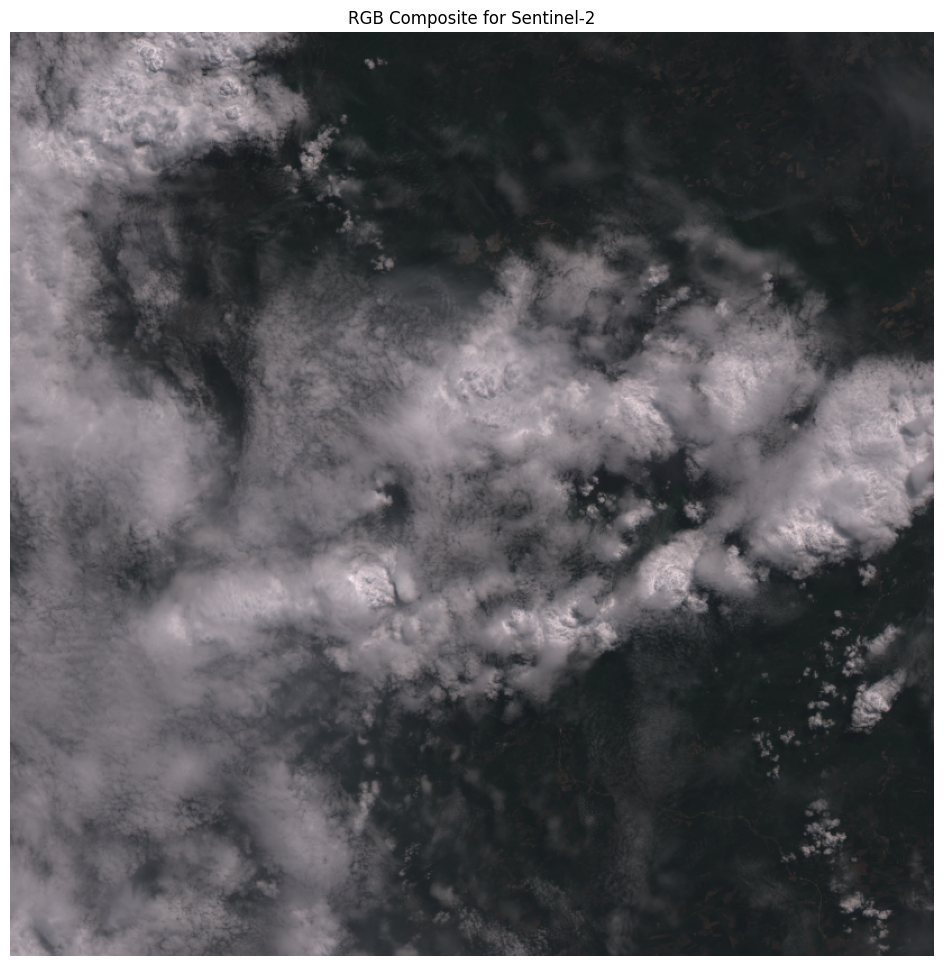

In [82]:
coarsen_factor = 20
boundary = 'trim'


red = ds.B04.coarsen(x=coarsen_factor, y=coarsen_factor, boundary=boundary).mean()
green = ds.B03.coarsen(x=coarsen_factor, y=coarsen_factor, boundary=boundary).mean()
blue = ds.B02.coarsen(x=coarsen_factor, y=coarsen_factor, boundary=boundary).mean()
rgb_array = np.stack([red.values, green.values, blue.values], axis=-1)


plt.figure(figsize=(12, 12))

# normalizing the array values
plt.imshow(rgb_array / np.max(rgb_array))

plt.title('RGB Composite for Sentinel-2')
plt.axis('off')
plt.show()
    

<div class="alert alert-block alert-info" style="width: 30%; margin-left: 200px; text-align: center;">
    <h4><b>Try it yourself !</b></h4>
    <p>Based on what we've learned so far, could you try to obtain <b>Normalized Difference Vegetation Index (NDVI)</b> for a small area in our imagery. You could also coarsen the array like above.</p>
    <p><a href="./ndvi.txt" target="_blank"><b>See Solution</b></a></p>

</div>




## Summary

In this notebook, we learnt 

* about cloud native data formats
* setting up account at Copernicus Data Space Ecosystem
* downloading Sentinel data using APIs
* converting data from SAFE format to Zarr format and 
* visualizing dataset from Zarr store